# Chen Identity Verification Example

This notebook demonstrates the Chen identity for path signatures by:
1. Splitting a path into 4 segments using augmentations
2. Computing signatures for each segment  
3. Concatenating them using the @ operator (Chen identity)
4. Comparing with the signature of the whole path

The Chen identity states that the signature of a concatenated path equals the product of the signatures of the individual segments.


In [1]:
import jax
import jax.numpy as jnp
import numpy as np
from quicksig.rdes.augmentations import non_overlapping_windower
from quicksig.signatures.compute_path_signature import compute_path_signature
from quicksig.signatures.signature_types import Signature

# Create a test path
key = jax.random.PRNGKey(42)
path_length = 100
n_dims = 3
path = jax.random.normal(key, (path_length, n_dims))

# Make it a proper path by taking cumulative sum
path = jnp.cumsum(path, axis=0)

print(f"Original path shape: {path.shape}")

# Split path into 4 segments by slicing to maintain continuity
# Calculate split points to get approximately 4 segments
num_segments = 4
split_points = [i * path_length // num_segments for i in range(num_segments + 1)]

segments = []
for i in range(num_segments):
    start_idx = split_points[i]
    end_idx = split_points[i + 1]
    # Each segment includes the endpoint to maintain continuity
    segment = path[start_idx:end_idx + 1] if end_idx < path_length else path[start_idx:]
    segments.append(segment)

print(f"Number of segments: {len(segments)}")
print(f"Segment shapes: {[seg.shape for seg in segments]}")
print(f"Split points: {split_points}")

# Check continuity by comparing endpoints  
for i in range(num_segments - 1):
    end_point = segments[i][-1]
    start_point = segments[i + 1][0]
    continuity_check = jnp.allclose(end_point, start_point)
    print(f"Segment {i} -> {i+1} continuity: {continuity_check}")

# Set signature depth
depth = 3

# Compute signatures for each segment and adjust intervals
segment_signatures = []

for i, segment in enumerate(segments):
    if segment.shape[0] > 1:  # Only compute if segment has more than 1 point
        sig = compute_path_signature(segment, depth=depth, mode="full")
        
        # Adjust the interval to reflect the actual position in the original path
        # Account for the overlapping boundary points
        start_idx = split_points[i]
        end_idx = split_points[i + 1]
        
        adjusted_sig = Signature(
            signature=sig.signature,
            interval=(start_idx, end_idx),
            ambient_dimension=sig.ambient_dimension,
            depth=sig.depth
        )
        
        segment_signatures.append(adjusted_sig)
        print(f"Segment {i} signature computed, interval: {adjusted_sig.interval}")

print(f"Valid segments for signature computation: {len(segment_signatures)}")

# Apply Chen identity using @ operator to concatenate segment signatures
print("\nApplying Chen identity...")
print("The Chen identity states: Sig(X₁ ∘ X₂ ∘ ... ∘ Xₙ) = Sig(X₁) @ Sig(X₂) @ ... @ Sig(Xₙ)")

# Start with the first segment signature
concatenated_signature = segment_signatures[0]

# Concatenate all segment signatures using @ operator
for i in range(1, len(segment_signatures)):
    concatenated_signature = concatenated_signature @ segment_signatures[i]
    print(f"Concatenated segment {i} signature")

print(f"Final concatenated signature interval: {concatenated_signature.interval}")

# Compute signature of the whole path
whole_path_signature = compute_path_signature(path, depth=depth, mode="full")
print(f"Whole path signature interval: {whole_path_signature.interval}")

# Compare the signatures
print(f"\nComparing signatures:")
print(f"Concatenated signature depth: {concatenated_signature.depth}")
print(f"Whole path signature depth: {whole_path_signature.depth}")
print(f"Concatenated signature dimensions: {concatenated_signature.ambient_dimension}")
print(f"Whole path signature dimensions: {whole_path_signature.ambient_dimension}")

# Check if they are equal level by level
tolerance = 1e-4  # Reasonable tolerance for floating point comparison
signatures_equal = True

print(f"\nDebugging signature shapes:")
print(f"Concatenated signature levels: {len(concatenated_signature.signature)}")
print(f"Whole path signature levels: {len(whole_path_signature.signature)}")

for level in range(depth):
    concat_level = concatenated_signature.signature[level]
    whole_level = whole_path_signature.signature[level]
    
    print(f"Level {level+1}: concat shape = {concat_level.shape}, whole shape = {whole_level.shape}")
    
    # Ensure both are flattened for comparison
    concat_flat = jnp.ravel(concat_level)
    whole_flat = jnp.ravel(whole_level)
    
    level_diff = jnp.abs(concat_flat - whole_flat)
    max_diff = jnp.max(level_diff)
    
    print(f"Level {level+1}: max difference = {max_diff}")
    
    if max_diff > tolerance:
        signatures_equal = False
        print(f"  Level {level+1} FAILED: difference {max_diff} > tolerance {tolerance}")
        break

if signatures_equal:
    print(f"\n✅ SUCCESS: Chen identity verified!")
    print(f"   Concatenated segment signatures match the whole path signature")
    print(f"   (within tolerance {tolerance})")
else:
    print(f"\n❌ FAILED: Chen identity verification failed!")
    print(f"   Signatures do not match within tolerance {tolerance}")

# Final assertion
assert signatures_equal, "Chen identity verification failed - signatures do not match!"
print("\n🎉 All assertions passed!")


Original path shape: (100, 3)
Number of segments: 4
Segment shapes: [(26, 3), (26, 3), (26, 3), (25, 3)]
Split points: [0, 25, 50, 75, 100]
Segment 0 -> 1 continuity: True
Segment 1 -> 2 continuity: True
Segment 2 -> 3 continuity: True
Segment 0 signature computed, interval: (0, 25)
Segment 1 signature computed, interval: (25, 50)
Segment 2 signature computed, interval: (50, 75)
Segment 3 signature computed, interval: (75, 100)
Valid segments for signature computation: 4

Applying Chen identity...
The Chen identity states: Sig(X₁ ∘ X₂ ∘ ... ∘ Xₙ) = Sig(X₁) @ Sig(X₂) @ ... @ Sig(Xₙ)
Concatenated segment 1 signature
Concatenated segment 2 signature
Concatenated segment 3 signature
Final concatenated signature interval: (0, 100)
Whole path signature interval: (0, 100)

Comparing signatures:
Concatenated signature depth: 3
Whole path signature depth: 3
Concatenated signature dimensions: 3
Whole path signature dimensions: 3

Debugging signature shapes:
Concatenated signature levels: 3
Whole

/tmp/ipykernel_418005/350449221.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


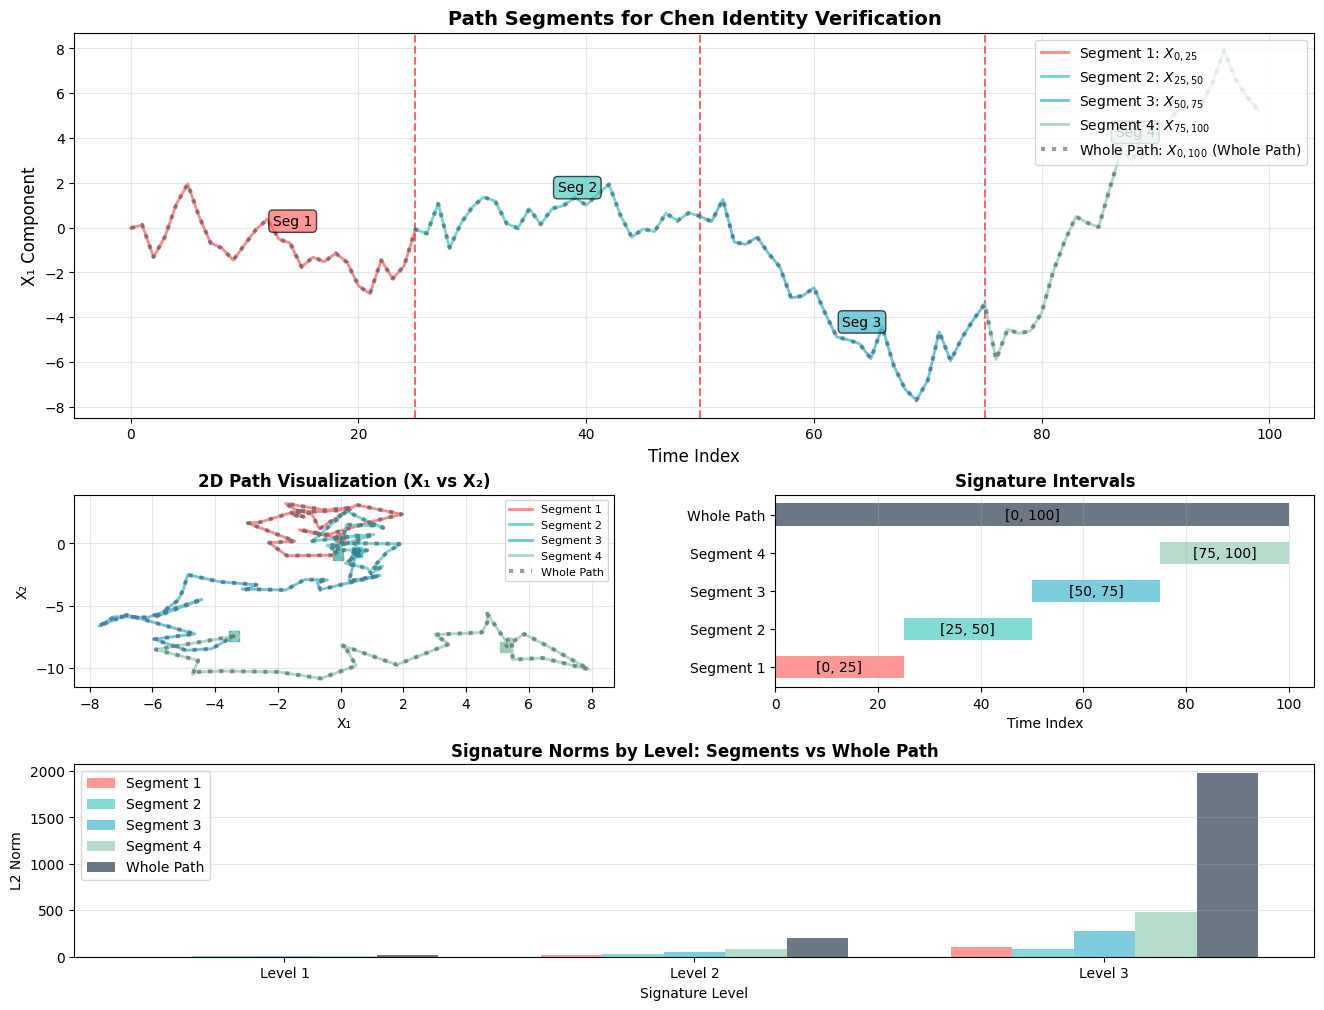


SIGNATURE WINDOW ANALYSIS - INCLUDING WHOLE PATH

Segment 1 ($X_{0,25}$):
  • Window: [0, 25] (length: 25)
  • Dimensions: 3
  • Depth: 3
  • Level 1 norm: 1.621449
  • Level 2 norm: 20.947989
  • Level 3 norm: 103.686684
  • Total norm (sum): 126.256121

Segment 2 ($X_{25,50}$):
  • Window: [25, 50] (length: 25)
  • Dimensions: 3
  • Depth: 3
  • Level 1 norm: 6.575964
  • Level 2 norm: 25.020660
  • Level 3 norm: 81.527931
  • Total norm (sum): 113.124556

Segment 3 ($X_{50,75}$):
  • Window: [50, 75] (length: 25)
  • Dimensions: 3
  • Depth: 3
  • Level 1 norm: 7.886230
  • Level 2 norm: 53.659309
  • Level 3 norm: 279.437592
  • Total norm (sum): 340.983130

Segment 4 ($X_{75,100}$):
  • Window: [75, 100] (length: 25)
  • Dimensions: 3
  • Depth: 3
  • Level 1 norm: 11.706122
  • Level 2 norm: 82.951218
  • Level 3 norm: 476.501740
  • Total norm (sum): 571.159080

Whole Path ($X_{0,100}$ (Whole Path)):
  • Window: [0, 100] (length: 100)
  • Dimensions: 3
  • Depth: 3
  • Level 1 

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create comprehensive visualization including whole path signature
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[2, 1, 1], hspace=0.3, wspace=0.3)

# Colors for different segments + whole path
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#2C3E50']  # Added dark blue for whole path
segment_labels = [f'$X_{{{split_points[i]},{split_points[i+1]}}}$' for i in range(num_segments)]
segment_labels.append(f'$X_{{0,{path_length}}}$ (Whole Path)')

# Combine segment signatures with whole path signature for analysis
all_signatures = segment_signatures + [whole_path_signature]
all_labels = [f'Segment {i+1}' for i in range(len(segment_signatures))] + ['Whole Path']

# Plot 1: Original path segments
ax1 = fig.add_subplot(gs[0, :])

# Plot each segment with different colors
for i, segment in enumerate(segments):
    start_idx = split_points[i]
    indices = np.arange(start_idx, start_idx + len(segment))
    
    # Plot the segment
    ax1.plot(indices, segment[:, 0], color=colors[i], linewidth=2, 
             label=f'Segment {i+1}: {segment_labels[i]}', alpha=0.8)
    
    # Mark segment boundaries
    if i < len(segments) - 1:
        ax1.axvline(x=split_points[i+1], color='red', linestyle='--', alpha=0.6)
    
    # Add segment annotation
    mid_idx = (start_idx + start_idx + len(segment)) // 2
    ax1.annotate(f'Seg {i+1}', xy=(mid_idx, segment[mid_idx - start_idx, 0]), 
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=colors[i], alpha=0.7),
                fontsize=10, ha='center')

# Overlay whole path with distinctive style
ax1.plot(range(path_length), path[:, 0], color=colors[4], linewidth=3, 
         alpha=0.5, linestyle=':', label=f'Whole Path: {segment_labels[4]}')

ax1.set_title('Path Segments for Chen Identity Verification', fontsize=14, fontweight='bold')
ax1.set_xlabel('Time Index', fontsize=12)
ax1.set_ylabel('X₁ Component', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: 2D path visualization (X1 vs X2)
ax2 = fig.add_subplot(gs[1, 0])

for i, segment in enumerate(segments):
    start_idx = split_points[i]
    ax2.plot(segment[:, 0], segment[:, 1], 
             color=colors[i], linewidth=2, alpha=0.8, label=f'Segment {i+1}')
    
    # Mark start and end points
    ax2.scatter([segment[0, 0]], [segment[0, 1]], 
               color=colors[i], s=50, marker='o')
    ax2.scatter([segment[-1, 0]], [segment[-1, 1]], 
               color=colors[i], s=50, marker='s')

# Overlay whole path
ax2.plot(path[:, 0], path[:, 1], color=colors[4], linewidth=3, 
         alpha=0.5, linestyle=':', label='Whole Path')

ax2.set_title('2D Path Visualization (X₁ vs X₂)', fontsize=12, fontweight='bold')
ax2.set_xlabel('X₁')
ax2.set_ylabel('X₂')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# Plot 3: Signature intervals and properties
ax3 = fig.add_subplot(gs[1, 1])

# Create a timeline showing signature intervals
y_positions = np.arange(len(all_signatures))
for i, sig in enumerate(all_signatures):
    start, end = sig.interval
    ax3.barh(y_positions[i], end - start, left=start, 
             color=colors[i], alpha=0.7, height=0.6)
    
    # Add interval labels
    ax3.text(start + (end - start) / 2, y_positions[i], 
             f'[{start}, {end}]', ha='center', va='center', fontsize=10)

ax3.set_yticks(y_positions)
ax3.set_yticklabels([f'{label}' for label in all_labels])
ax3.set_xlabel('Time Index')
ax3.set_title('Signature Intervals', fontsize=12, fontweight='bold')
ax3.grid(True, axis='x', alpha=0.3)

# Plot 4: Signature norms by level
ax4 = fig.add_subplot(gs[2, :])

# Compute signature norms for each level
levels = range(1, depth + 1)
width = 0.15  # Adjusted for 5 bars
x_positions = np.arange(len(levels))

for i, sig in enumerate(all_signatures):
    norms = []
    for level in range(depth):
        level_sig = sig.signature[level]
        norm = float(jnp.linalg.norm(jnp.ravel(level_sig)))
        norms.append(norm)
    
    bar_style = '--' if i == len(all_signatures) - 1 else '-'  # Different style for whole path
    ax4.bar(x_positions + i * width, norms, width, 
            color=colors[i], alpha=0.7, label=f'{all_labels[i]}')

ax4.set_xlabel('Signature Level')
ax4.set_ylabel('L2 Norm')
ax4.set_title('Signature Norms by Level: Segments vs Whole Path', fontsize=12, fontweight='bold')
ax4.set_xticks(x_positions + width * (len(all_signatures) - 1) / 2)
ax4.set_xticklabels([f'Level {i}' for i in levels])
ax4.legend()
ax4.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Display signature intervals and properties
print("\n" + "="*80)
print("SIGNATURE WINDOW ANALYSIS - INCLUDING WHOLE PATH")
print("="*80)

for i, sig in enumerate(all_signatures):
    start, end = sig.interval
    window_length = end - start
    label = segment_labels[i] if i < len(segment_labels) else f'Signature {i+1}'
    
    print(f"\n{all_labels[i]} ({label}):")
    print(f"  • Window: [{start}, {end}] (length: {window_length})")
    print(f"  • Dimensions: {sig.ambient_dimension}")
    print(f"  • Depth: {sig.depth}")
    
    # Show signature norms for each level
    level_norms = []
    for level in range(sig.depth):
        level_sig = sig.signature[level]
        norm = float(jnp.linalg.norm(jnp.ravel(level_sig)))
        level_norms.append(norm)
        print(f"  • Level {level+1} norm: {norm:.6f}")
    
    # Show total signature norm (sum of all levels)
    total_norm = sum(level_norms)
    print(f"  • Total norm (sum): {total_norm:.6f}")

print(f"\nTotal path length: {path_length}")
print(f"Segment coverage: {sum(end - start for start, end in [sig.interval for sig in segment_signatures])}")

# Additional statistics comparing segments to whole path
print("\n" + "="*80)
print("COMPARATIVE ANALYSIS: SEGMENTS vs WHOLE PATH")
print("="*80)

whole_path_norms = []
for level in range(depth):
    level_sig = whole_path_signature.signature[level]
    norm = float(jnp.linalg.norm(jnp.ravel(level_sig)))
    whole_path_norms.append(norm)

print(f"\nWhole path signature norms by level:")
for i, norm in enumerate(whole_path_norms):
    print(f"  Level {i+1}: {norm:.6f}")

print(f"\nSum of segment norms vs whole path norm by level:")
for level in range(depth):
    segment_sum = sum(float(jnp.linalg.norm(jnp.ravel(sig.signature[level]))) 
                     for sig in segment_signatures)
    whole_norm = whole_path_norms[level]
    ratio = segment_sum / whole_norm if whole_norm > 0 else float('inf')
    print(f"  Level {level+1}: Σ(segments) = {segment_sum:.6f}, Whole = {whole_norm:.6f}, Ratio = {ratio:.3f}")

print(f"\nTotal signature energy:")
segment_total = sum(sum(float(jnp.linalg.norm(jnp.ravel(sig.signature[level]))) 
                       for level in range(sig.depth)) for sig in segment_signatures)
whole_total = sum(whole_path_norms)
print(f"  Sum of all segment norms: {segment_total:.6f}")
print(f"  Whole path norm: {whole_total:.6f}")
print(f"  Ratio: {segment_total / whole_total:.3f}")

# Chen identity verification summary
print(f"\n📊 Chen Identity Verification Summary:")
print(f"  • Concatenated signature matches whole path: {'✅ YES' if signatures_equal else '❌ NO'}")
print(f"  • Tolerance used: {tolerance}")
print(f"  • Maximum difference found: {max_diff:.2e}")
print(f"  • Number of signature levels: {depth}")
print(f"  • Path dimensions: {n_dims}")
print(f"  • Number of segments: {num_segments}")
